### Vegetation loss (extent) case study
Hinchinbrook Island, QLD  
Mangrove extent loss due to cyclone Yasi in 2011  
Impact = Vegetation loss (extent)  
Pressure = Excess rainfall, strong winds, Storm surge  


#### Data
Impacts observed through DEA Land Cover  
Level 3 change assessed  
Level 4 change assessed  
Perhaps changes are linked to potential impacts?  
Where impact is identified, goes to config file of potential pressures and this links to virtual products  


In [58]:
import sys
import numpy as np
import xarray as xr
import geopandas as gpd
import datacube

import matplotlib.pyplot as plt

from datacube.utils.geometry import Geometry, CRS
from dea_tools.plotting import rgb, display_map

dc = datacube.Datacube()

# impacts and pressures functions
sys.path.append('/home/jovyan/code/living_coasts/functions')
from impacts import vegetation_loss, vegetation_damage

# for virtual products
import yaml
import importlib
from datacube.virtual import catalog_from_file
from datacube.virtual import DEFAULT_RESOLVER
catalog = catalog_from_file('../virtual_products/vegetation_loss_config.yaml')
sys.path.append('/home/jovyan/code/living_coasts/virtual_products')

ScannerError: while scanning a simple key
  in "<unicode string>", line 24, column 9
could not find expected ':'
  in "<unicode string>", line 25, column 9

### User inputs

In [36]:
# add in vector data for area of interest
AOI = '../data/vector_data/AOIs/Hinchinbrook_Island.geojson'
AOI = gpd.read_file(AOI)

# annual years of change for identifying impact
pre_impact_year = '2010'
post_impact_year = '2011'

In [37]:
display_map(x=(AOI.total_bounds[0], AOI.total_bounds[2]), y=(AOI.total_bounds[1], AOI.total_bounds[3]))

In [38]:
# datacube query
resolution = (-25,25) # collection 2 = 25m, collection 3 = 30m
query_pre_impact = {
    'time': (pre_impact_year, pre_impact_year),
    'resolution':resolution}

query_post_impact = {
    'time': (post_impact_year, post_impact_year),
    'resolution':resolution}

# Loop through polygons in geodataframe and extract satellite data
for index, row in AOI.iterrows(): 
    # Extract the feature's geometry as a datacube geometry object (this needs to be updated eventually for Shapely 2.0)
    geom = Geometry(geom=row.geometry, crs=AOI.crs)
    # Update the query to include our geopolygon
    query_pre_impact.update({'geopolygon': geom})
    query_post_impact.update({'geopolygon': geom})

## Impact = Vegetation loss (extent)
Observed through DEA Land Cover

In [39]:
vegetation_loss = vegetation_loss(query_pre_impact, query_post_impact)

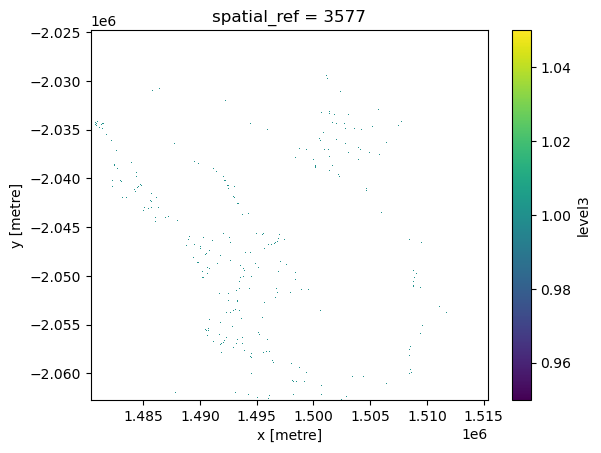

In [40]:
vegetation_loss.plot()

## Impact = Vegetation Damage (strong winds)
Observed through DEA Land Cover

In [64]:
def vegetation_damage(query_pre_impact, query_post_impact):
    '''
    Vegetation damage (strong winds)
    Definition: Harm that impairs the value or function of plants or plant communities.

    # Level 3
    Cultivated terrestrial vegetation (111) --> Cultivated terrestrial vegetation (111)
    Natural terrestrial vegetation (112) --> Natural terrestrial vegetation (112)
    Natural aquatic vegetation (124) --> Natural aquatic vegetation (124)
    
    # Level 4
    Vegetation Cover (Canopyco_veg_cat14d)
    Closed >65% (10) --> Open 40% - 65% (12) OR Open 15% to 40% (13) OR Sparse (4% to 15%) OR Scattered 1 to 4% (16)
    Open 40% - 65% (12) --> Open 15% to 40% (13) OR Sparse (4% to 15%) OR Scattered 1 to 4%
    Open 15% to 40% (13) --> Sparse (4% to 15%) OR Scattered 1 to 4%
    Sparse (4% to 15%) --> Scattered 1 to 4% (16)
    '''
    # Load in Land cover for time periods
    pre_impact_year = dc.load(
        product="ga_ls_landcover_class_cyear_2",
        output_crs="EPSG:3577",
        measurements=["level3", "vegetation_cover"],
        **query_pre_impact)

    post_impact_year = dc.load(
        product="ga_ls_landcover_class_cyear_2",
        output_crs="EPSG:3577",
        measurements=["level3", "vegetation_cover"],
        **query_post_impact)

    # Combine years into one xr.Dataset
    combined = xr.concat([pre_impact_year, post_impact_year], dim="time")
    combined_level3 = combined.level3
    combined_vegetation_cover = combined.vegetation_cover

    # Create where statements for vegetation damage
    condition_1 = (combined_level3[0] == 111) & (combined_level3[1] == 111) & \
                  (combined_vegetation_cover[0] == 10) & \
                  ((combined_vegetation_cover[1] == 12) | 
                   (combined_vegetation_cover[1] == 13) | 
                   (combined_vegetation_cover[1] == 16))

    condition_2 = (combined_level3[0] == 112) & (combined_level3[1] == 112) & \
                  (combined_vegetation_cover[0] == 10) & \
                  ((combined_vegetation_cover[1] == 12) | 
                   (combined_vegetation_cover[1] == 13) | 
                   (combined_vegetation_cover[1] == 16))

    condition_3 = (combined_level3[0] == 124) & (combined_level3[1] == 124) & \
                  (combined_vegetation_cover[0] == 10) & \
                  ((combined_vegetation_cover[1] == 12) | 
                   (combined_vegetation_cover[1] == 13) | 
                   (combined_vegetation_cover[1] == 16))

    vegetation_damage = xr.where(condition_1 | condition_2 | condition_3, 1, np.nan)

    return vegetation_damage


In [65]:
vegetation_damage = vegetation_damage(query_pre_impact, query_post_impact)

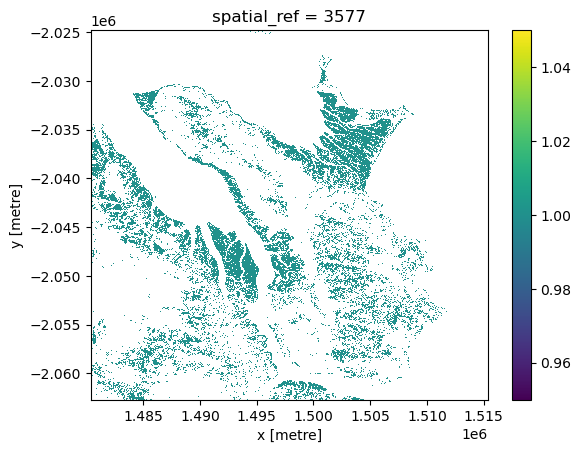

In [66]:
vegetation_damage.plot()

## Potential Pressures

### Bushfire
- idea here is to load for each time series the NBR
- then calc dNBR and threshold with burnt area like here (https://knowledge.dea.ga.gov.au/notebooks/Real_world_examples/Burnt_area_mapping/)
- then mask based on pixels from impact data
- print out % pixels affected by potential pressure

In [13]:
# Need to add any tranformations for the VP you're using

# Get location of transformation
transformation = 'bushfire'
trans_loc = importlib.import_module(transformation)
trans_class = transformation.split('.')[-1]

DEFAULT_RESOLVER.register('transform', trans_class, getattr(trans_loc, trans_class))

ModuleNotFoundError: No module named 'bushfire'

In [ ]:
# see what's already in the resolver 
DEFAULT_RESOLVER.lookup_table['transform']

In [ ]:
# load bushfire
product = catalog['bushfire']
bushfire_pre_impact = product.load(dc, **query_pre_impact)

